# <center> Trajectory of a particle under the action of a magnetic field </center>
<center> Trajetória de uma partícula sob ação de um campo magnético </center>

------------------------------------

The main goal of this project is to calculate the trajectory of a particle acting on a magnetic field.

These are the equations used:

- Newton's movement law
$$
\vec{F} = m \cdot \vec{a} = \frac{d\vec{v}}{dt}
$$

- Lorentz force
$$
\vec{F} = q (\vec{E} + \vec{v} \times \vec{B})
$$

- Lorentz factor
$$
\gamma = \frac{1}{\sqrt{1 - \left(\frac{\vec{v}}{c} \right)^2}}
$$

- Runge-Kutta 4th order method
$$
u^{n+1} = u^n + \Delta t \sum_{i=1}^{e}b_i k_i
$$

where

$$
k_i = F(u^n + \Delta t \sum_{j-i}^{e}a_{ij}k_j;t_n+c_i \Delta t) i=1, ..., e
$$

## Data

Please, edit only the next cell

In [1]:
''' ==== particle features ==== '''
m = 939.3      # mass (MeV/c²)
q = 1          # charge


''' ==== initial conditions ==== '''
x0, y0, z0 = -0.05, 0, 0     # initial position (m)
v_direction = [1, 0, 0]
Ec0 = 10        # initial kinetic energy (MeV)


''' ==== time conditions ==== '''
step = 1e-11      # time step (used for RK4)
total_t = 1e-8     # total elapsed time (s)


''' ==== loading data ==== '''
file_name = "2017-03-06_BD-004_Model09_Hall_I=991.63A.dat"      # file containing the data to be uploaded
magnet_name = "BD-004"
magnet_type = "dipole"
magnet_length = 0.25
current_main = 991.63


''' ==== saving data ==== '''
output_file = True 
txt_name = "2017-03-06_BD-004_teste"


''' ==== graphic visualization ==== '''
output_graphic = True

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import RectBivariateSpline, RegularGridInterpolator
from datetime import datetime, date, time
import math

## Main

In [13]:
# defines the eletric field at each point
def e_field(x, y, z): 
      Ex = 0
      Ey = 2
      Ez = 0
      return Ex, Ey, Ez


  # creates the interpolator
def create_interpolators(df):
    x_vals = np.sort(df.x_mm.unique())
    y_vals = np.sort(df.y_mm.unique())
    z_vals = np.sort(df.z_mm.unique())
    
    pivot_df = df.pivot_table(    
        index="y_mm", 
        columns="x_mm", 
        values="Bz_T",
        aggfunc='mean'
    )
    pivot_df = pivot_df.reindex(index=y_vals, columns=x_vals)
    Bz_grid = pivot_df.values

# check if there's enough data to apply spline interpolation
    if len(x_vals) >= 4 and len(y_vals) >= 4:
        try:
            kx = min(3, len(x_vals) - 1)
            ky = min(3, len(y_vals) - 1)
            Bz_interp = RectBivariateSpline(y_vals, x_vals, Bz_grid, kx=kx, ky=ky)
            interp_type = "spline"
        except:
            Bz_interp = RegularGridInterpolator((y_vals, x_vals), Bz_grid, 
                                           bounds_error=False, 
                                                fill_value=0.0)
            interp_type = "regular"
    else:
        Bz_interp = RegularGridInterpolator((y_vals, x_vals), Bz_grid, 
                                           bounds_error=False, 
                                           fill_value=0.0)
        interp_type = "regular"
    
    return {
        'x_vals': x_vals,
        'y_vals': y_vals,
        'z_vals': z_vals,
        'Bz_interp': Bz_interp,
        'interp_type': interp_type
    }

# defines the magnetic field at each point
def b_field(x, y, z, interp_data):
    x_mm = x * 1000
    y_mm = y * 1000
    z_mm = z * 1000
    
    x_vals = interp_data['x_vals']
    y_vals = interp_data['y_vals']
    Bz_interp = interp_data['Bz_interp']
    interp_type = interp_data['interp_type']

    # check the limits
    in_x_range = (x_mm >= x_vals.min() and x_mm <= x_vals.max())
    in_y_range = (y_mm >= y_vals.min() and y_mm <= y_vals.max())
    if not (in_x_range and in_y_range):
        return 0, 0, 0
    try:
        if interp_type == "spline":
            # RectBivariateSpline
            Bz = float(Bz_interp(y_mm, x_mm, grid=False)) * 1e-3 
        else:
            # RegularGridInterpolator
            Bz = float(Bz_interp([[y_mm, x_mm]])[0]) * 1e-3  
    except Exception as e:
        Bz = 0
    
    Bx = 0
    By = 0
    
    return Bx, By, Bz


def main_func(m, q, x0, y0, z0, b_field, e_field, Ec0, v_direction, step, total_t, output_file, txt_name, file_name, magnet_name, magnet_type, magnet_length, current_main):

    # data import
    df = pd.read_csv(file_name, 
                     sep="\t", 
                     skiprows=15)
    
    df.drop(index=[0], inplace=True)
    df = df.dropna(axis=1)
    df = df.set_axis(["x_mm", "y_mm", "z_mm", "Bx_T", "By_T", "Bz_T"], axis=1)
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna()

    interp_data = create_interpolators(df)


    c = 2.99792458e8      # light speed (m/s)

    
    conv_m = m * 1.78266e-30      # converted mass (Kg)
    conv_q = q * 1.60218e-19        # converted charge (C)
    const = conv_q/conv_m


    gamma = 1.0 + (Ec0 / m)

    conv_v = (np.sqrt(1.0 - 1.0/(gamma**2))) * c  # converted speed (m/s)


    ux = v_direction[0]
    uy = v_direction[1]
    uz = v_direction[2]
    u = np.array([ux, uy, uz], dtype=float)
    u_hat = u / np.linalg.norm(u)
    Vx, Vy, Vz = conv_v * u_hat          # x, y and z velocitys (m/s)

    x, y, z = x0, y0, z0       # initial position



    def acceleration(x, y, z, Vx, Vy, Vz):
        Bx, By, Bz = b_field(x, y, z, interp_data)
        Ex, Ey, Ez = e_field(x, y, z)

        V2 = Vx**2 + Vy**2 + Vz**2           # squared velocity

        if V2 >= c**2:
            gamma = 1.0e10 
        else:
            gamma = 1.0 / np.sqrt(1.0 - V2/c**2)
    
        ax2 = const/gamma*((Ex+Vy*Bz-Vz*By)-((Vx/c**2)*Vx*Ex+Vy*Ey+Vz*Ez))
        ay2 = const/gamma*((Ey+Vz*Bx-Vx*Bz)-((Vy/c**2)*Vx*Ex+Vy*Ey+Vz*Ez))
        az2 = const/gamma*((Ez+Vx*By-Vy*Bx)-((Vz/c**2)*Vx*Ex+Vy*Ey+Vz*Ez))
        
        return ax2, ay2, az2

    
    def rk4(x, y, z, Vx, Vy, Vz, step): 
        # k1
        ax1, ay1, az1 = acceleration(x, y, z, Vx, Vy, Vz)
        k1_x = Vx        
        k1_y = Vy        
        k1_z = Vz         
        k1_Vx = ax1     
        k1_Vy = ay1      
        k1_Vz = az1        
    
        # k2 
        x2 = x + 0.5*step * k1_x
        y2 = y + 0.5*step * k1_y
        z2 = z + 0.5*step * k1_z
        Vx2 = Vx + 0.5*step * k1_Vx
        Vy2 = Vy + 0.5*step * k1_Vy
        Vz2 = Vz + 0.5*step * k1_Vz
    
        ax2, ay2, az2 = acceleration(x2, y2, z2, Vx2, Vy2, Vz2)
        k2_x = Vx2   
        k2_y = Vy2
        k2_z = Vz2
        k2_Vx = ax2
        k2_Vy = ay2
        k2_Vz = az2
    
        # k3 
        x3 = x + 0.5*step * k2_x
        y3 = y + 0.5*step * k2_y
        z3 = z + 0.5*step * k2_z
        Vx3 = Vx + 0.5*step * k2_Vx
        Vy3 = Vy + 0.5*step * k2_Vy
        Vz3 = Vz + 0.5*step * k2_Vz
    
        ax3, ay3, az3 = acceleration(x3, y3, z3, Vx3, Vy3, Vz3)
        k3_x = Vx3
        k3_y = Vy3
        k3_z = Vz3
        k3_Vx = ax3
        k3_Vy = ay3
        k3_Vz = az3
    
        # k4
        x4 = x + step * k3_x
        y4 = y + step * k3_y
        z4 = z + step * k3_z
        Vx4 = Vx + step * k3_Vx
        Vy4 = Vy + step * k3_Vy
        Vz4 = Vz + step * k3_Vz
    
        ax4, ay4, az4 = acceleration(x4, y4, z4, Vx4, Vy4, Vz4)
        k4_x = Vx4
        k4_y = Vy4
        k4_z = Vz4
        k4_Vx = ax4
        k4_Vy = ay4
        k4_Vz = az4
    
        new_x = x + (step/6.0) * (k1_x + 2*k2_x + 2*k3_x + k4_x)
        new_y = y + (step/6.0) * (k1_y + 2*k2_y + 2*k3_y + k4_y)
        new_z = z + (step/6.0) * (k1_z + 2*k2_z + 2*k3_z + k4_z)
        new_Vx = Vx + (step/6.0) * (k1_Vx + 2*k2_Vx + 2*k3_Vx + k4_Vx)
        new_Vy = Vy + (step/6.0) * (k1_Vy + 2*k2_Vy + 2*k3_Vy + k4_Vy)
        new_Vz = Vz + (step/6.0) * (k1_Vz + 2*k2_Vz + 2*k3_Vz + k4_Vz)
    
        return new_x, new_y, new_z, new_Vx, new_Vy, new_Vz


    x_vals = np.zeros(int(total_t/step))
    y_vals = np.zeros(int(total_t/step))
    z_vals = np.zeros(int(total_t/step))
    Vx_vals = np.zeros(int(total_t/step))
    Vy_vals = np.zeros(int(total_t/step))
    Vz_vals = np.zeros(int(total_t/step))
    t_vals = np.zeros(int(total_t/step))

    
    for i in range(int(total_t/step)):
        x_vals[i], y_vals[i], z_vals[i] = x, y, z
        Vx_vals[i], Vy_vals[i], Vz_vals[i] = Vx, Vy, Vz
        t_vals[i] = i*step
    
        x, y, z, Vx, Vy, Vz = rk4(x, y, z, Vx, Vy, Vz, step)


    data = np.column_stack((x_vals, y_vals, z_vals, Vx_vals, Vy_vals, Vz_vals, t_vals))
    data = np.delete(data, np.where(data[:,0]>magnet_length), axis=0)

    
    if output_file == True:
        df_save = pd.DataFrame(data, columns=['x(m)', 'y(m)', 'z(m)', 'Vx(m/s)', 'Vy(m/s)', 'Vz(m/s)', 't(s)'])
        df_save.to_csv(f"{txt_name}.csv", index=False, float_format='%.12e')
    simulation_params = {
        'magnet_name': f'{magnet_name}',
        'timestamp': datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
        'filename': f'{txt_name}',
        'magnet_type': f'{magnet_type}',
        '': '',
        'magnet_length[mm]': f'{magnet_length}',
        'current_main[A]': f'{current_main}',
        '': '', 
        'particle_mass[MeV/c²]': f'{m}',
        'particle_charge[e]': f'{q}',
        'initial_kinetic_energy[MeV]': f'{Ec0}',
        'initial_position[m]': f'({x0}, {y0}, {z0})',
        'initial_velocity_direction': f'{v_direction}',
        'initial_speed[m/s]': f'{conv_v:.6e}',
        'time_step[s]': f'{step:.3e}',
        'total_time[s]': f'{total_t:.3e}',
        'number_of_steps': f'{total_t/step:.3e}',
        '': '',
        'Data columns': 'x(m), y(m), z(m), Vx(m/s), Vy(m/s), Vz(m/s), t(s)'
    }
    header_lines = []
    for key, value in simulation_params.items():
        if key == '':
            header_lines.append('')
        elif key == 'Data columns':
            header_lines.append(f'{value}')
        else:
            header_lines.append(f'{key}: {value}')
    header_str = '\n'.join(header_lines)
    np.savetxt(f"{txt_name}.txt", data, 
               fmt='%.12e', delimiter=',', 
               header=header_str,
               comments='# ',
               encoding='utf-8')

    
    if output_graphic == True:
        fig = plt.figure(figsize=(15, 15))

        ax1 = fig.add_subplot(321) 
        ax4 = fig.add_subplot(322) 

        tempo = np.linspace(0, total_t, len(df_save))

        ax1.plot(df_save['x(m)'], df_save['y(m)'], 'palevioletred', linewidth=1.5)
        ax1.set_xlabel('X (m)')
        ax1.set_ylabel('Y (m)')
        ax1.grid(True)
        ax1.axis()
        ax1.set_title('XY trajectory')

        ax4.plot(df_save['z(m)'], tempo, 'teal', linewidth=1.5, alpha=0.7)
        ax4.set_xlabel('Z (m)')
        ax4.set_ylabel('Tempo')
        ax4.grid(True)
        ax4.set_title('Z trajectory')
        plt.tight_layout()
        plt.show()


        # graphic compairison of magnetic fields and positions
        fig = go.Figure()
        fig.add_trace(go.Scatter3d(
            x=df['x_mm'],
            y=df['y_mm'],
            z=df['z_mm'],
            mode='markers',
            marker=dict(
                size=5,
                color=df["Bx_T"], 
                colorscale='tealrose',
                opacity=0.8,
                colorbar=dict(title='Bx(T)')
            )
        ))
        fig.update_layout(
            title='X-axis magnetic field',
            scene=dict(
                xaxis_title='x (m)',
                yaxis_title='y (m)',
                zaxis_title='z (m)',
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=1.5)
                )
            ),
            width=800,
            height=600,
            margin=dict(r=20, l=10, b=10, t=40)
        )
        fig.show()

        fig = go.Figure()
        fig.add_trace(go.Scatter3d(
            x=df['x_mm'],
            y=df['y_mm'],
            z=df['z_mm'],
            mode='markers',
            marker=dict(
                size=5,
                color=df["By_T"], 
                colorscale='tealrose',
                opacity=0.8,
                colorbar=dict(title='By(T)')
            )
        ))
        fig.update_layout(
            title='Y-axis magnetic field',
            scene=dict(
                xaxis_title='x (m)',
                yaxis_title='y (m)',
                zaxis_title='z (m)',
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=1.5)
                )
            ),
            width=800,
            height=600,
            margin=dict(r=20, l=10, b=10, t=40)
        )
        fig.show()


        fig = go.Figure()
        fig.add_trace(go.Scatter3d(
            x=df['x_mm'],
            y=df['y_mm'],
            z=df['z_mm'],
            mode='markers',
            marker=dict(
                size=5,
                color=df["Bz_T"], 
                colorscale='tealrose',
                opacity=0.8,
                colorbar=dict(title='Bz(T)')
            )
        ))
        fig.update_layout(
            title='Z-axis magnetic field',
            scene=dict(
                xaxis_title='x (m)',
                yaxis_title='y (m)',
                zaxis_title='z (m)',
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=1.5)
                )
            ),
            width=800,
            height=600,
            margin=dict(r=20, l=10, b=10, t=40)
        )
        fig.show()
        

        fig = go.Figure()
        fig.add_trace(go.Scatter3d(
            x=df_save['x(m)'],
            y=df_save['y(m)'],
            z=df_save['z(m)'],
            mode='markers'
        ))
        fig.update_layout(
            title='3D Trajectory',
            scene=dict(
                xaxis_title='x (m)',
                yaxis_title='y (m)',
                zaxis_title='z (m)',
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=1.5)
                )
            ),
            width=800,
            height=600,
            margin=dict(r=20, l=10, b=10, t=40)
        )
        fig.show()

        
        plt.figure(figsize=(6,5))
        plt.scatter(df["x_mm"], df["z_mm"], c=df["Bz_T"])
        plt.colorbar(label="Bz (T)")
        plt.xlabel("X (mm)")
        plt.ylabel("Z (mm)")
        plt.title("Measured Field (X–Z plane)")
        plt.tight_layout()
        plt.show()


        # deviation degree
        x_list = np.sort(df_save["x(m)"])
        dist_x = x_list[-1] - x_list[0]

        angle = math.atan(x_list[0]/dist_x)
        degree_angle = math.degrees(angle)
        print(f'The deviation degree is approximately {degree_angle:.2f}°')
        

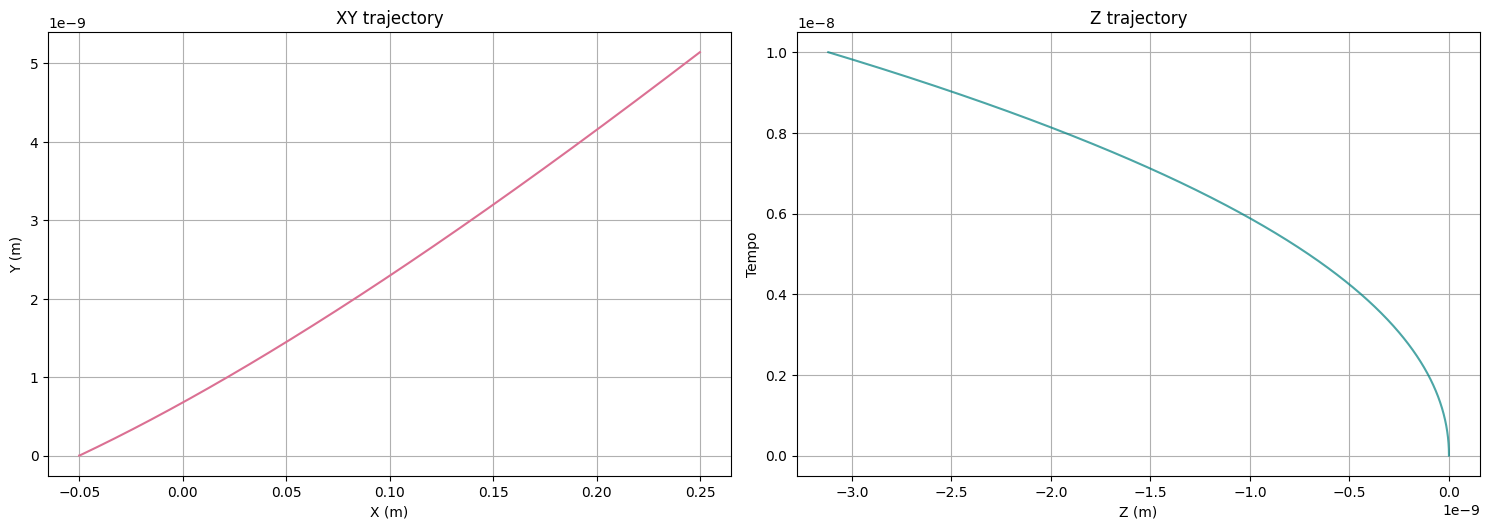

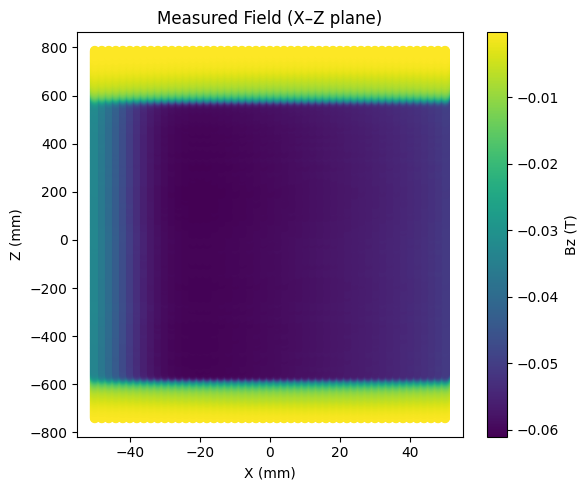

The deviation degree is approximately -9.47°


In [14]:
main_func(m, q, x0, y0, z0, b_field, e_field, Ec0, v_direction, step, total_t, output_file, txt_name, file_name, magnet_name, magnet_type, magnet_length, current_main)

Melhorias e dúvidas
- remover o desvio em y